上一节，我们略微提到了奇异值分解。现在，这节课我们来进一步领略一下奇异值分解的魅力

# 什么是奇异值分解？

## 奇异值分解  $Singular$ $Value$ $Decomposition$ $(SVD)$

奇异值分解是一个能适用于任意矩阵的一种分解的方法，对于任意矩阵A总是存在一个奇异值分解：

$$A=U\Sigma V^T$$

假设A是一个$m*n$的矩阵，那么得到的$U$是一个$m*m$的方阵，$U$里面的正交向量被称为左奇异向量。  
$Σ$是一个$m*n$的矩阵，$Σ$除了对角线其它元素都为0，对角线上的元素称为奇异值。  
$V^T$是$V$的转置矩阵，是一个$n*n$的矩阵，它里面的正交向量被称为右奇异值向量。  
而且一般来讲，我们会将$Σ$上的值按从大到小的顺序排列。


## SVD分解矩阵A的步骤：

1) 求的$AA^T$特征值和特征向量，用单位化的特征向量构成$U$。  
2) 求的$A^TA$特征值和特征向量，用单位化的特征向量构成$V$。  
3) 将$AA^T$或者$A^TA$的特征值求平方根，然后构成$Σ$。

## 用np自带包实现！

In [1]:
import pandas as pd
#读取OD数据
TaxiOD = pd.read_csv(r'data-sample/TaxiOD.csv')
TaxiOD.columns = ['VehicleNum', 'Stime', 'SLng', 'SLat', 
       'ELng', 'ELat','Etime']
TaxiOD.head(5)

,VehicleNum,Stime,SLng,SLat,ELng,ELat,Etime
0,22223,00:03:23,114.167465,22.562468,114.225235,22.552750,00:10:48
1,22223,00:11:33,114.227150,22.554167,114.229218,22.560217,00:15:19
2,22223,00:17:13,114.231354,22.562166,114.255798,22.590967,00:29:06
3,22223,00:36:45,114.240196,22.563650,114.119965,22.566668,00:54:42
4,22223,01:01:14,114.135414,22.575933,114.166748,22.608267,01:08:17


In [51]:
#按每10分钟集计OD
TaxiOD['Etime_30min'] = TaxiOD['Etime'].str.slice(0,3)+((TaxiOD['Etime'].str.slice(3,4).astype('int')/3).astype('int')*3).astype('str')+'0:00'

In [6]:
#栅格化代码
import math
#定义一个测试栅格划的经纬度
testlon = 114
testlat = 22.5

#划定栅格划分范围
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748

latStart = min(lat1, lat2);
lonStart = min(lon1, lon2);

#定义栅格大小(单位m)
accuracy = 500;

#计算栅格的经纬度增加量大小▲Lon和▲Lat
deltaLon = accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360));
deltaLat = accuracy * 360 / (2 * math.pi * 6371004);

#计算栅格的经纬度编号
LONCOL=divmod(float(testlon) - (lonStart - deltaLon / 2) , deltaLon)[0]
LATCOL=divmod(float(testlat) - (latStart - deltaLat / 2) , deltaLat)[0]

#计算栅格的中心点经纬度
HBLON = LONCOL*deltaLon + (lonStart - deltaLon / 2)#格子编号*格子宽+起始横坐标-半个格子宽=格子中心横坐标
HBLAT = LATCOL*deltaLat + (latStart - deltaLat / 2)

#把算好的东西print出来看看
LONCOL,LATCOL,HBLON,HBLAT,deltaLon,deltaLat

(51.0,
 12.0,
 113.99800701150498,
 22.499547959873865,
 0.004872614089207591,
 0.004496605206422906)

In [57]:
TaxiOD = TaxiOD[-TaxiOD['ELng'].isnull()].copy()
TaxiOD['SLONCOL'] = ((TaxiOD['SLng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
TaxiOD['SLATCOL'] = ((TaxiOD['SLat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
TaxiOD['SHBLON'] = TaxiOD['SLONCOL']*deltaLon + (lonStart - deltaLon / 2)
TaxiOD['SHBLAT'] = TaxiOD['SLATCOL']*deltaLat + (latStart - deltaLat / 2)
TaxiOD['ELONCOL'] = ((TaxiOD['ELng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
TaxiOD['ELATCOL'] = ((TaxiOD['ELat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
TaxiOD['EHBLON'] = TaxiOD['ELONCOL']*deltaLon + (lonStart - deltaLon / 2)
TaxiOD['EHBLAT'] = TaxiOD['ELATCOL']*deltaLat + (latStart - deltaLat / 2)

In [58]:
TaxiOD['OD'] = TaxiOD['SLONCOL'].astype('str')+','+\
TaxiOD['SLATCOL'].astype('str')+'-'+TaxiOD['ELONCOL'].astype('str')+','+\
TaxiOD['ELATCOL'].astype('str')

In [59]:
matrix = TaxiOD.groupby(['OD','Etime_30min'])['VehicleNum'].count()\
.reset_index().pivot(columns= 'Etime_30min',index='OD',values = 'VehicleNum').fillna(0)

In [63]:
matrix = matrix[(matrix==0).sum(axis = 1)<40]

In [64]:
matrix

Etime_30min,00:00:00,00:30:00,01:00:00,01:30:00,02:00:00,02:30:00,03:00:00,03:30:00,04:00:00,04:30:00,...,19:00:00,19:30:00,20:00:00,20:30:00,21:00:00,21:30:00,22:00:00,22:30:00,23:00:00,23:30:00
OD,,,,,,,,,,,,,,,,,,,,,
"100,59-100,60",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
"100,59-100,61",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"100,59-101,62",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,2.0,1.0,1.0,2.0,0.0,0.0,1.0,0.0
"100,59-94,61",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"100,59-96,62",2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,2.0,0.0,1.0,2.0,1.0,0.0,4.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"99,62-100,60",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
"99,62-101,62",2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,3.0,0.0,1.0,2.0
"99,62-102,64",1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,2.0,1.0


In [65]:
from numpy import linalg as la
import numpy as np
U,sigma,VT=la.svd(matrix.values.T)
for i in range(U.shape[0]):
    flag = np.sign(U[:,i][abs(U[:,i])==abs(U[:,i]).max()][0])
    U[:,i] = flag*U[:,i]
    VT[i,:] = flag*VT[i,:]
nsigma = (sigma/sum(sigma)).round(3)


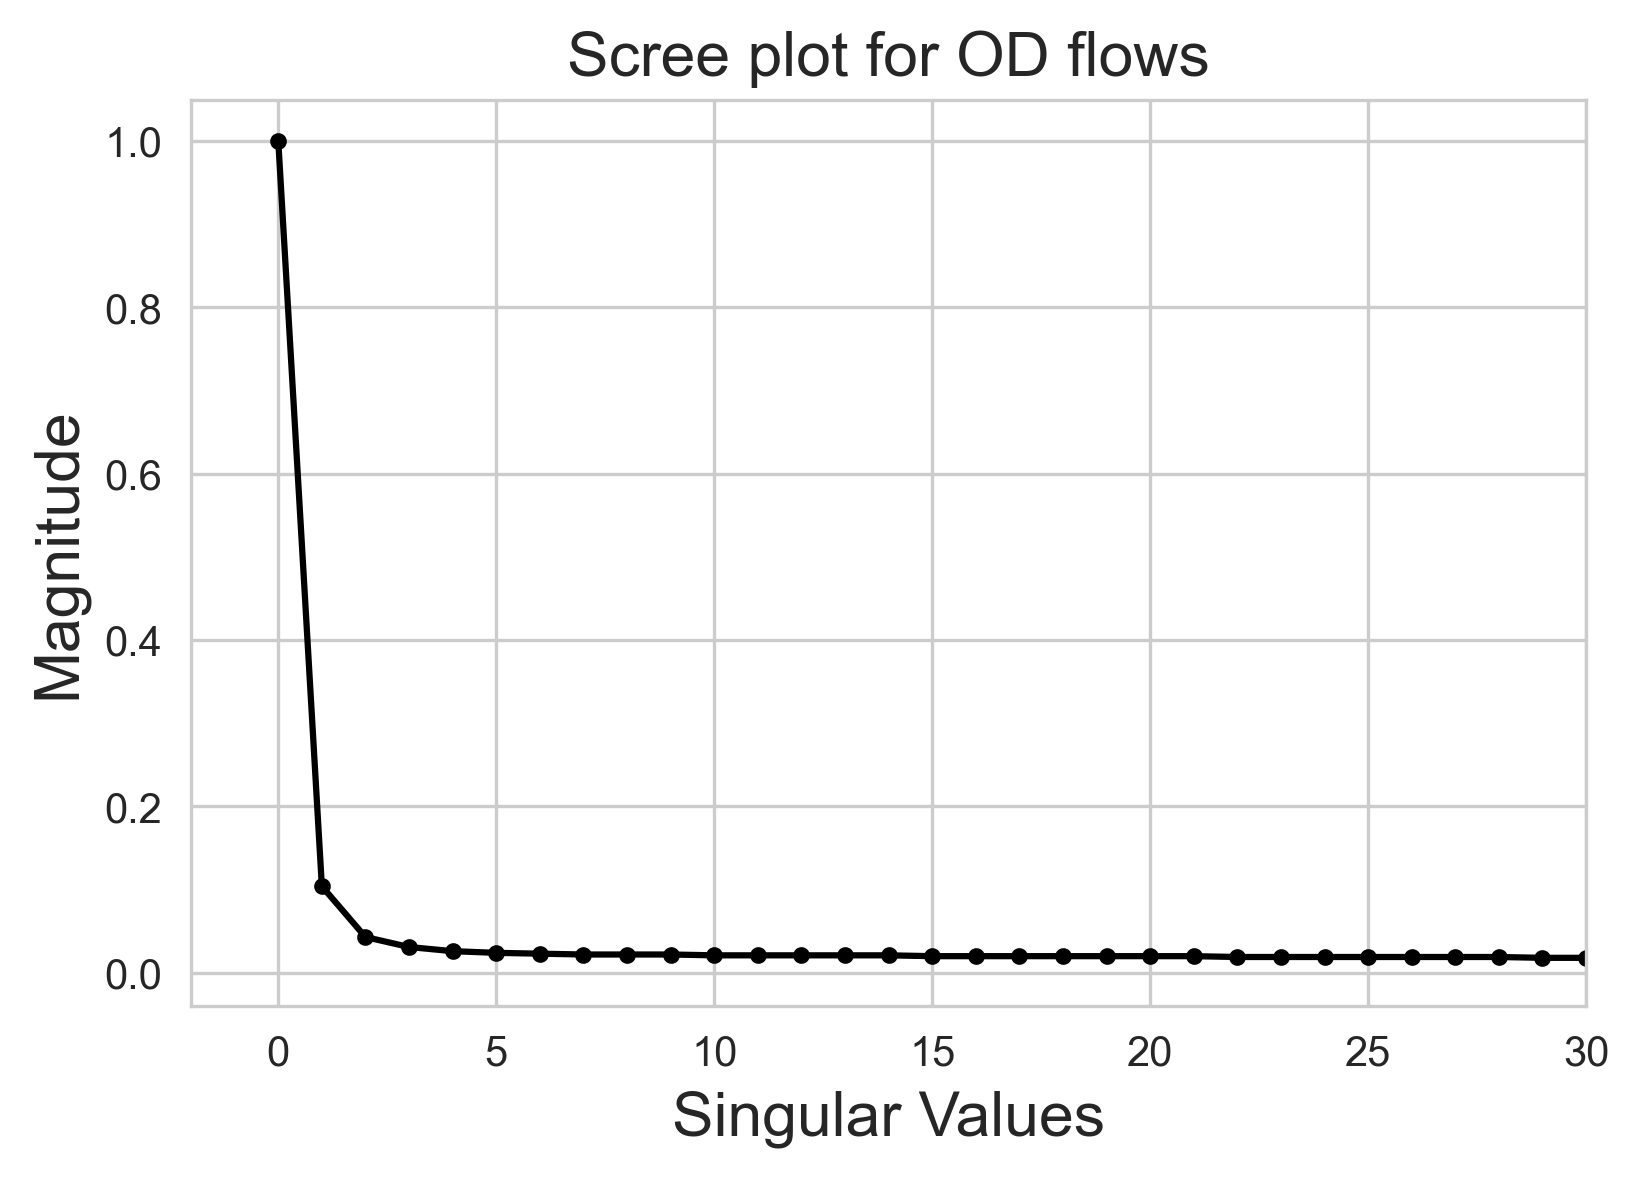

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid',{"xtick.major.size": 10 , "ytick.major.size": 10})
plt.figure(1,(6,4),dpi = 300)

plt.plot(range(0,len(nsigma)+1),[1]+list(nsigma),'k-',range(0,len(nsigma)+1),[1]+list(nsigma),'k.')
plt.title('Scree plot for OD flows',size = 15)
plt.xlabel('Singular Values',size = 15)
plt.ylabel('Magnitude',size = 15)
plt.xlim(-2,30)
plt.show()

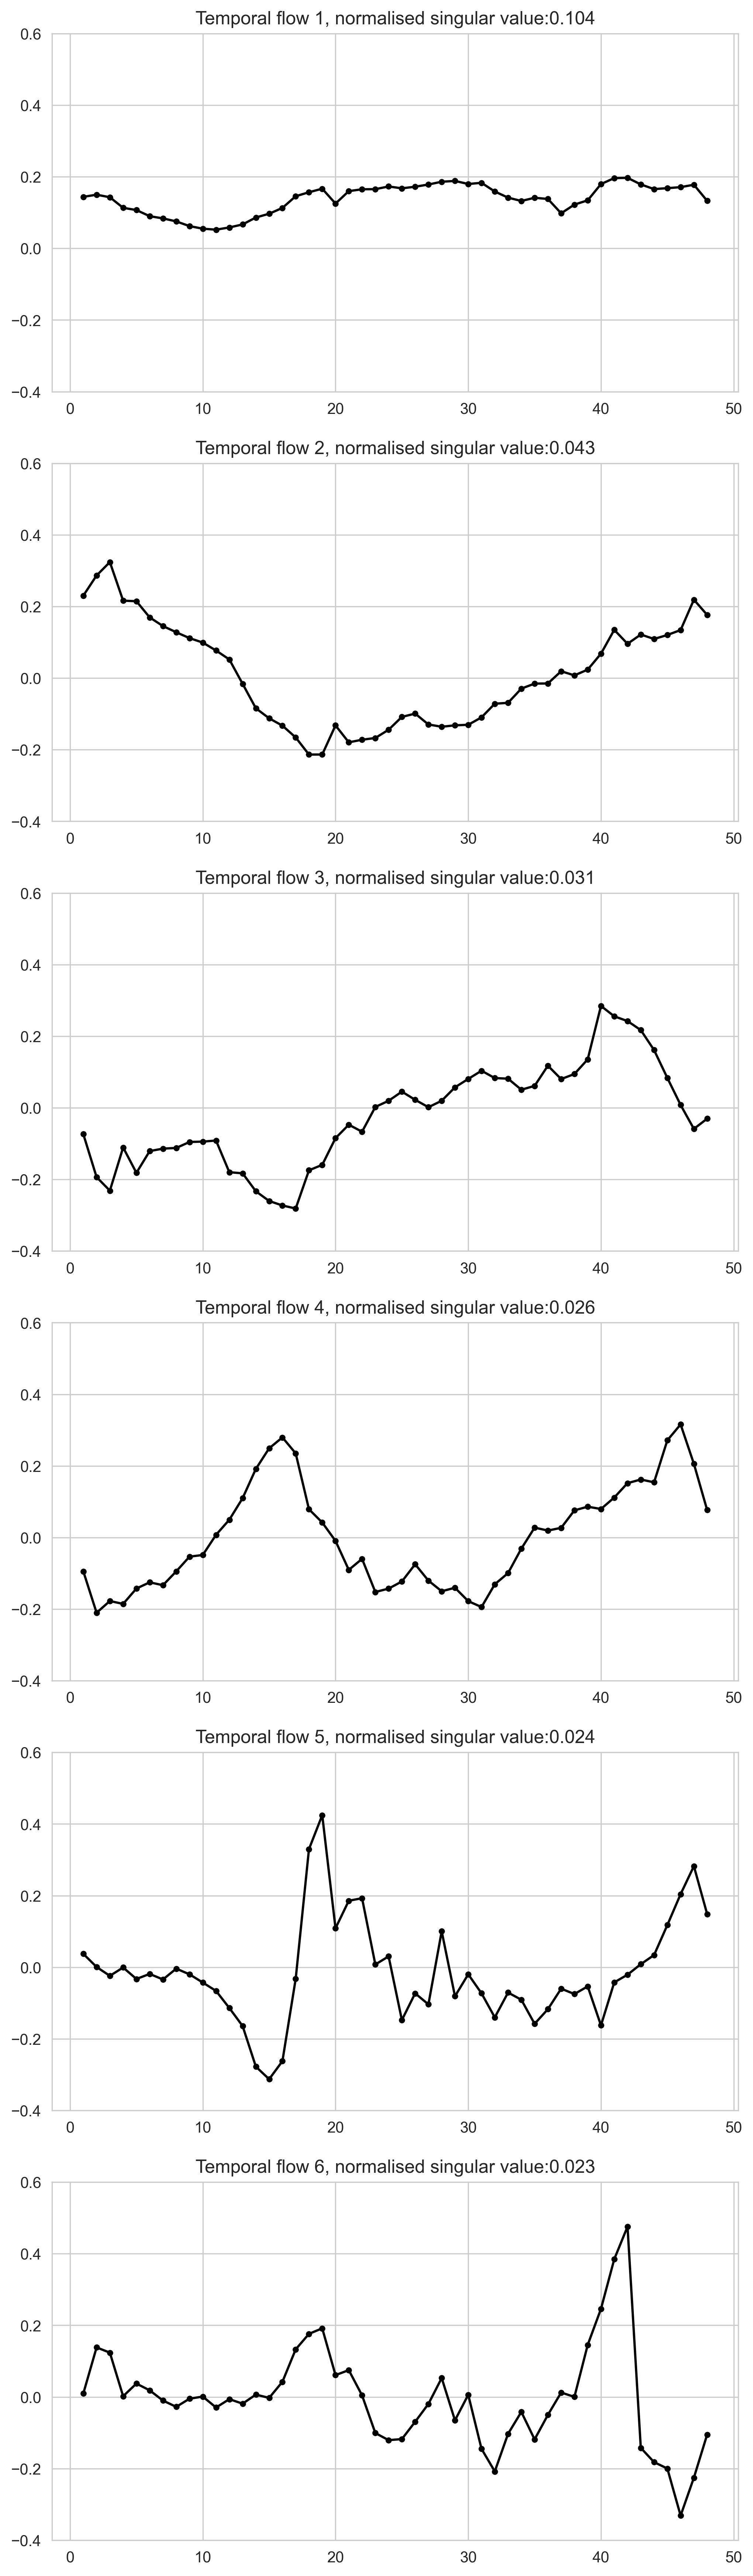

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
#创建一个图
sns.set_style('whitegrid',{"xtick.major.size": 10 , "ytick.major.size": 10})
a = 10
b = 3
fig, axs = plt.subplots(6, 1, figsize=(8, 30), sharey=True,dpi = 300)

for i in range(6):
    plt.sca(axs.reshape(1,6)[0][i])
    plt.plot(range(1,len(nsigma)+1),U[:,i],'k-',range(1,len(nsigma)+1),U[:,i],'k.')

    plt.title('Temporal flow '+str(i+1)+', normalised singular value:'+str(nsigma[i]))
    #plt.legend(frameon = 1)
    plt.ylim(-0.4,0.6)

plt.show()